This notebook coves the topic of identifying which celebrities JUUL targeted to promote their vaping product.

For researchers who would prefer to work with optical character recognition (OCR) text for JUUL vs State of North Carolina case from within their own database systems, these files are available for free download via the link below.
https://ucsf.app.box.com/v/IDL-DataSets/file/1447029625798

Note: The link provides access to the most current dataset, as the website undergoes a new release each month. Ensure that you have sufficient storage available to download the zip file with the OCR text (7-9 GB).


#### Step 1: Retrieve documents ids relevant to the query using the API wrapper

Import the required libraries

In [ ]:
import requests
import re
import pandas as pd
import zipfile, csv, os, sys

Code to retrieve document ids which will then be used to retrieve OCR text

In [ ]:
# Define the query_solr_api function
def query_solr_api(query, format='json', sort_field='id', cursor_mark='*'):
    global ids_list  # Declare ids_list as global
    base_api = f'https://solr.idl.ucsf.edu/solr/ltdl3/query?q={query}&wt={format}'
    ids_list = []  # Initialize the global ids_list

    # while loop to retrieve documents, the loop will run as long as the cursor mark is valid
    while cursor_mark:
        api_final = f"{base_api}&cursorMark={cursor_mark}&sort={sort_field}%20desc"  # constructs the final API url with the current cursor_mark and sorting.
        try:
            response = requests.get(api_final)
            response.raise_for_status()
        except requests.exceptions.RequestException as e:
            print(f"Error: {e}")
            break

        data = response.json()
        documents = data.get('response', {}).get('docs', [])  # extracts the list of documents from the response.
        ids_list.extend([doc['id'] for doc in documents if 'id' in doc])  # adds the id of each document to ids_list if it exists.

        # prints information about the current step
        print(f"Retrieved {len(documents)} documents. Total IDs collected: {len(ids_list)}")

        # retrieves the next cursor mark for next set of documents. Checks if the cursor_mark hasn't changed to avoid an infinite loop, breaking the loop if it hasn't.
        next_cursor_mark = data.get('nextCursorMark', None)
        if cursor_mark == next_cursor_mark:
            break
        cursor_mark = next_cursor_mark

    # Final output information
    print(f"Total number of document IDs collected: {len(ids_list)}")
    print(f"Last cursor mark used: {cursor_mark}")

    return ids_list

# Example usage of the function
def main():
    query = '(collection:"JUUL labs Collection" AND case:"State of North Carolina" AND "celebrity" AND type:"Email")' # modify as required
    ids_list = query_solr_api(query)

    # Save the collected IDs and query input to a CSV file
    output_df = pd.DataFrame({'Document ID': ids_list})
    output_df.to_csv('collected_document_ids.csv', index=False)
    print(f"Collected document IDs saved to 'collected_document_ids.csv'")

# Ensures that main function is called only if the script is run directly (not imported as a module)
if __name__ == "__main__":
    main()

Use the document ids retrieved in the previous query to extract relevant OCR text and save it as a CSV

In [ ]:
zip_file_path = 'JUUL_Labs_Collection.zip'          # modify the file paths as required
output_csv = 'retrieved_ocr_texts.csv'              # modify the file paths as required
ids_csv_path = 'collected_document_ids.csv'         # modify the file paths as required

# Reads the document IDs from the collected_document_ids.csv file and returns them as a list.
def read_ids_from_csv(ids_csv_path):
    with open(ids_csv_path, 'r', encoding='utf-8') as file:
        reader = csv.reader(file)
        ids_list = [row[0] for row in reader]
    return ids_list


# Uses the list of IDs obtained from the read_ids_from_csv function to filter and write the desired OCR text data to output_csv.
def extract_data_from_csvs(zip_file_path, ids_csv_path, output_csv):
    ids_list = read_ids_from_csv(ids_csv_path)
    ids_set = set(ids_list)
    csv.field_size_limit(sys.maxsize)

    with zipfile.ZipFile(zip_file_path, 'r') as z:
        with open(output_csv, 'w', newline='', encoding='utf-8') as out_file:
            writer = csv.writer(out_file)
            writer.writerow(['id', 'text'])

            for file_name in z.namelist():
                with z.open(file_name) as csvfile:
                    lines = (line.decode('utf-8').replace('\0', '') for line in csvfile)
                    reader = csv.reader(lines, delimiter='|')
                    for row in reader:
                        if row and row[0] in ids_set:
                            #print(f"Processing ID: {row[0]}") # use the print statement to monitor the progress of the OCR text filtering
                            writer.writerow([row[0], row[-1]])

extract_data_from_csvs(zip_file_path, ids_csv_path, output_csv)

Sanity check: The documents are updated periodically and hence the ocr text for all ids may not be available in the zip file. Run the code cell below to check the document ids for which OCR text was not extracted from the zip file.

In [ ]:
def check_missing_ids(zip_file_path, ids_csv_path, output_csv):
    ids_list = read_ids_from_csv(ids_csv_path)
    ids_set = set(ids_list)
    extracted_ids = set()

    with open(output_csv, 'r', encoding='utf-8') as file:
        reader = csv.reader(file)
        next(reader)  # Skip header row
        for row in reader:
            extracted_ids.add(row[0])

    missing_ids = list(ids_set - extracted_ids)
    if missing_ids:
        print("OCR text was not extracted for the following IDs:")
        print(missing_ids) # print the list of missing IDs
        print(f"Count of missing IDs: {len(missing_ids)}") # print the count of missing IDs
    else:
        print("All IDs were successfully processed.")

check_missing_ids(zip_file_path, ids_csv_path, output_csv)


Example of output for missing_ids

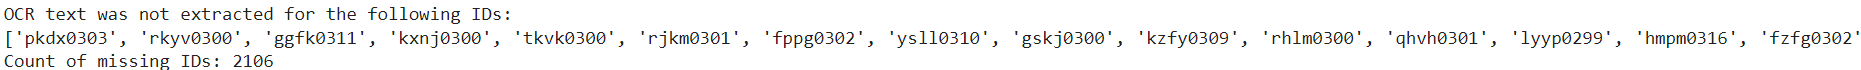


#### Named Entity Recognition (NER) is a method that identifies and classifies key information within the text into predefined categories such as names of people, organizations, locations, dates, and other entities.

#### For instance, NER can be used to identify key celebrities and organizations within the legal documents. This can be achieved using BERT (Bidirectional Encoder Representations from Transformers) which is a model designed to help machines understand human language more effectively. It's based on a type of neural network architecture called a transformer, which is particularly good at processing sequences of data, like sentences.

#### Transformer-based models can be fine-tuned for specific tasks by training them on specialized datasets. The model's ability to recognize different categories, such as sentiment, named entities, or topics, depends on what data it was trained on.



Run the code cell below to perform name entity recognition analysis directly using the OCR text (email). The output is seperated by each individual tag for ease of analysis

In [ ]:
from transformers import AutoTokenizer, AutoModelForTokenClassification, pipeline
from itertools import tee, islice

# Load the CSV file
df = pd.read_csv('retrieved_ocr_texts.csv')

# Initialize the BERT NER model and tokenizer
model_name = "dslim/bert-large-NER"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForTokenClassification.from_pretrained(model_name)

# Initialize the pipeline
ner_pipeline = pipeline("ner", model=model, tokenizer=tokenizer, aggregation_strategy="simple")

# Function to extract text between "Subject:"/"Re:" and "CONFIDENTIAL".
# This function searches for text between "Subject:" or "Re:" and "CONFIDENTIAL" within a given text to extract content from the email body.

def extract_relevant_text(text):
    match = re.search(r'Subject:.*?CONFIDENTIAL|Re:.*?CONFIDENTIAL', text, re.DOTALL)
    if match:
        relevant_text = match.group(0)
        # Remove 'CONFIDENTIAL' and the leading part up to "Subject:" or "Re:"
        relevant_text = re.sub(r'(Subject:|Re:)', '', relevant_text)
        relevant_text = relevant_text.replace('CONFIDENTIAL', '').strip()
        return relevant_text
    return ""

# Function to extract NER tags
def extract_ner_tags(text):
    ner_results = ner_pipeline(text)
    return ner_results

# Function to get unigrams and bigrams from a list of words
def get_unigrams_and_bigrams(words):
    unigrams = words
    bigrams = [' '.join(bigram) for bigram in zip(words, islice(words, 1, None))]
    return unigrams + bigrams

# Process each OCR text and extract NER tags
ner_data = []
for index, row in df.head(10).iterrows():
    doc_id = row['id']
    text = extract_relevant_text(row['text'])
    if text:
        ner_results = extract_ner_tags(text)
        for result in ner_results:
            word = result['word']
            # Check if 'entity_group' is present, otherwise use 'entity'
            entity = result.get('entity_group', result.get('entity'))
            ner_data.append({'id': doc_id, 'word': word, 'tag': entity})

# Convert the results to a DataFrame
ner_df = pd.DataFrame(ner_data)

# Create separate DataFrames for each tag category
categories = ner_df['tag'].unique()
for category in categories:
    category_df = ner_df[ner_df['tag'] == category]

    # For PERSON tags, ensure unigrams and bigrams to capture more meaningful names
    if category == 'B-PER':
        # Group words by document ID to form bigrams within the same document
        category_df_grouped = category_df.groupby('id')['word'].apply(list).reset_index()
        expanded_data = []
        for _, row in category_df_grouped.iterrows():
            doc_id = row['id']
            words = row['word']
            unigrams_and_bigrams = get_unigrams_and_bigrams(words)
            for token in unigrams_and_bigrams:
                expanded_data.append({'id': doc_id, 'word': token, 'tag': 'B-PER'})
        category_df = pd.DataFrame(expanded_data)

    # Save each category to a separate CSV file
    output_path = f'ner_output_{category}.csv'
    category_df.to_csv(output_path, index=False)

#### The output may require some manual oversight. Here's an example of what the output looks like

Run the code cell below to remove duplicates in the word column for the person file. This is useful in cases where you you want a more concise list of words.

In [ ]:
# Remove duplicates in ner_output_PER based on word column
# Load the CSV file
df = pd.read_csv('ner_output_PER.csv') # modify file path as required

# Remove duplicates based on the 'word' column
df_cleaned = df.drop_duplicates(subset=['word'])

# Save the de-duplicated DataFrame to a new CSV file
df_cleaned.to_csv('ner_output_PER_cleaned.csv', index=False)

Run the code cell below to remove duplicates in the word column for the location file

In [ ]:
# Remove duplicates in ner_output_LOC based on word column
# Load the CSV file
df = pd.read_csv('ner_output_LOC.csv') # modify file path as required

# Remove duplicates based on the 'word' column
df_cleaned = df.drop_duplicates(subset=['word'])

# Save the de-duplicated DataFrame to a new CSV file
df_cleaned.to_csv('ner_output_LOC_cleaned.csv', index=False)


Run the code cell below to remove duplicates in the word column for the organization file

In [ ]:
# Remove duplicates in ner_output_ORG based on word column
# Load the CSV file
df = pd.read_csv('ner_output_ORG.csv') # modify file path as required

# Remove duplicates based on the 'word' column
df_cleaned = df.drop_duplicates(subset=['word'])

# Save the de-duplicated DataFrame to a new CSV file
df_cleaned.to_csv('ner_output_ORG_cleaned.csv', index=False)

Run the code cell below to remove duplicates in the word column for the words tagged as miscellaneous file

In [ ]:
# Remove duplicates in ner_output_MISC based on word column
# Load the CSV file
df = pd.read_csv('ner_output_MISC.csv') # modify file path as required

# Remove duplicates based on the 'word' column
df_cleaned = df.drop_duplicates(subset=['word'])

# Save the de-duplicated DataFrame to a new CSV file
df_cleaned.to_csv('ner_output_MISC_cleaned.csv', index=False)

Similarly, the following model can be used to extract keywords from the OCR text

In [ ]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM, pipeline

# Load the CSV file
df = pd.read_csv('retrieved_ocr_texts.csv')

# Initialize the keyword extraction model and tokenizer
model_name = "transformer3/H2-keywordextractor"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSeq2SeqLM.from_pretrained(model_name)

# Create a pipeline for keyword extraction
keyword_extraction_pipeline = pipeline("text2text-generation", model=model, tokenizer=tokenizer)

# Function to extract text between "Subject:"/"Re:" and "CONFIDENTIAL".
# This function searches for text between "Subject:" or "Re:" and "CONFIDENTIAL" within a given text to extract content from the email body.
def extract_relevant_text(text):
    match = re.search(r'(Subject:|Re:).*?(CONFIDENTIAL|$)', text, re.DOTALL)
    if match:
        relevant_text = match.group(0)
        # Remove 'CONFIDENTIAL' and the leading part up to "Subject:" or "Re:"
        relevant_text = re.sub(r'(Subject:|Re:)', '', relevant_text)
        relevant_text = relevant_text.replace('CONFIDENTIAL', '').strip()
        return relevant_text
    return ""

# Function to extract keywords
def extract_keywords(text):
    keyword_results = keyword_extraction_pipeline(text)
    return keyword_results

# Process each OCR text and extract keywords
keyword_data = []
for index, row in df.iterrows():
    doc_id = row['id']
    text = extract_relevant_text(row['text'])
    if text:
        keyword_results = extract_keywords(text)
        for result in keyword_results:
            keywords = result['generated_text'].split(", ")
            for keyword in keywords:
                keyword_data.append({'id': doc_id, 'keyword': keyword})

# Convert the results to a DataFrame
keyword_df = pd.DataFrame(keyword_data)

# Save the results to a new CSV file
output_path = 'keyword_output.csv'
keyword_df.to_csv(output_path, index=False)